# GAN Project
## Liz Parker, Colin Craighead, and Aren Dalloul

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from keras import layers
from keras import models
from keras import utils
from keras.optimizers import Adam
import tensorflow.keras.preprocessing.image as img
import scipy.io

from keras.datasets.mnist import load_data
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU

from PIL import Image

## Preparing the Dataset

array([0.], dtype=float32)

In [2]:
test_mat = scipy.io.loadmat("data/test_data.mat")
train_mat = scipy.io.loadmat("data/train_data.mat")

In [7]:
def unpack_mat(mat, train_or_test):
    df = pd.DataFrame()
    paths = []
    breeds = []
    breed_ids = []
    num_datapoints = len(mat[train_or_test][0][0][0])
    for i in range(num_datapoints):
        path = "images/" + mat[train_or_test][0][0][0][i][0][0]
        paths.append(path)
        temp_arr = mat[train_or_test][0][0][1][i][0][0].strip().split('-')
        breed_str = "-".join(temp_arr[1:]).split('/')[0]
        breeds.append(breed_str)
        breed_ids.append(mat[train_or_test][0][0][2][i][0])
    df['breed'] = breeds
    df['breed_id'] = breed_ids
    df['path'] = paths
    return df

In [8]:
train_df = unpack_mat(train_mat, 'train_info')
test_df = unpack_mat(test_mat, 'test_info')
train_df.head()

#TO REMOVE !!!!!!!!!!!!!
train_df = train_df.truncate(after = 1000)

In [56]:
train_df

,breed,breed_id,path
0,Chihuahua,1,images/n02085620-Chihuahua/n02085620_5927.jpg
1,Chihuahua,1,images/n02085620-Chihuahua/n02085620_4441.jpg
2,Chihuahua,1,images/n02085620-Chihuahua/n02085620_1502.jpg
3,Chihuahua,1,images/n02085620-Chihuahua/n02085620_1916.jpg
4,Chihuahua,1,images/n02085620-Chihuahua/n02085620_13151.jpg
...,...,...,...
996,Afghan_hound,10,images/n02088094-Afghan_hound/n02088094_2522.jpg
997,Afghan_hound,10,images/n02088094-Afghan_hound/n02088094_5436.jpg
998,Afghan_hound,10,images/n02088094-Afghan_hound/n02088094_4635.jpg
999,Afghan_hound,10,images/n02088094-Afghan_hound/n02088094_4598.jpg


In [57]:
X_train = np.array([img.img_to_array(img.load_img(path, target_size = (400,400))) for path in train_df['path']])

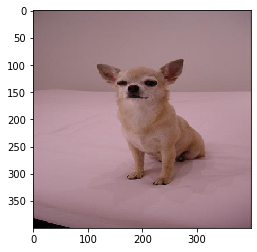

In [45]:
plt.imshow(X_train[1].astype('uint8'))

In [130]:
#Build Descriminator

descriminator = models.Sequential()
descriminator.add(layers.Conv2D(128,(3,3), strides=(2, 2), input_shape=(400,400,3)))
descriminator.add(layers.LeakyReLU(alpha=0.2))
descriminator.add(layers.Conv2D(128,(3,3), strides=(2, 2)))
descriminator.add(layers.LeakyReLU(alpha=0.2))
#descriminator.add(Dropout(0.4))
descriminator.add(Flatten())
descriminator.add(layers.Dense(1, activation='sigmoid'))

In [131]:
opt = Adam(lr=0.0002, beta_1=0.5)
descriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
descriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 199, 199, 128)     3584      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 199, 199, 128)     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 99, 99, 128)       147584    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 99, 99, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1254528)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1254529   
Total params: 1,405,697
Trainable params: 1,405,697
Non-trainable params: 0
____________________________________________

In [132]:
# load and prepare mnist training images
def load_real_samples():
    # expand to 3d, e.g. add channels dimension
#     X = expand_dims(X_train, axis=-1)
    # convert from unsigned ints to floats
    X = X_train.astype('float32')
    # scale from [0,255] to [0,1]
    X = X / 255.0
    return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y
 
# generate n fake samples with class labels
def generate_fake_samples(n_samples):
    # generate uniform random numbers in [0,1]
    X = rand(400 * 400 * n_samples * 3)
    print(X)
    # reshape into a batch of grayscale images
    X = X.reshape((n_samples, 400, 400, 3))
    # generate 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y
 
# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_iter):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator on real samples
        _, real_acc = model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        # update discriminator on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        # summarize performance
        print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [ ]:
# load image data
dataset = load_real_samples()
# fit the model
train_discriminator(descriminator, dataset)

[0.26656185 0.05025976 0.29805186 ... 0.83120083 0.99523693 0.66231958]
>1 real=0% fake=0%
[0.531737   0.29833123 0.62731885 ... 0.56081506 0.08151145 0.22727145]


In [ ]:
#Build Generator

In [ ]:
#Train

In [ ]:
#Test